In [1]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# Load data
# file_path = '../data/statcast-short.csv'
file_path = '../data/statcast_data_2016_2023.csv'
data = pd.read_csv(file_path)

/tmp/ipykernel_488771/677716641.py:4: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
data["game_date"] = pd.to_datetime(data["game_date"])

# How many pitches per year?
data["game_date"].dt.year.value_counts().sort_index()

game_date
2016    716073
2017    721244
2018    721190
2019    749399
2020    263584
2021    709852
2022    712392
2023    717945
Name: count, dtype: int64

In [4]:
# Preprocess data
data['events'].fillna(data["description"], inplace=True)
event_to_idx = {event: idx for idx, event in enumerate(data['events'].unique())}
idx_to_event = {idx: event for event, idx in event_to_idx.items()}
data['event_idx'] = data['events'].map(event_to_idx)

/tmp/ipykernel_488771/2871076944.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['events'].fillna(data["description"], inplace=True)


In [83]:
data["events"].value_counts()

events
ball                            1510090
foul                             838517
called_strike                    730005
field_out                        486327
swinging_strike                  319935
strikeout                        273985
single                           174926
blocked_ball                     103828
walk                              99124
double                            54737
home_run                          39505
foul_tip                          25602
force_out                         24662
grounded_into_double_play         23434
hit_by_pitch                      13006
foul_bunt                         10559
swinging_strike_blocked            9118
field_error                        8629
sac_fly                            7789
triple                             5127
sac_bunt                           4954
double_play                        2787
fielders_choice                    2531
intent_ball                        2318
missed_bunt                      

In [5]:
# Combine batters and pitchers to get all players
all_players = pd.concat([data['batter'], data['pitcher']]).unique()

# Create a LabelEncoder for all players
le_players = LabelEncoder()
le_players.fit(all_players)

# Transform batter and pitcher columns
data['batter'] = le_players.transform(data['batter'])
data['pitcher'] = le_players.transform(data['pitcher'])

# Get the number of unique players
num_players = len(le_players.classes_)

In [6]:
# Create a LabelEncoder for pitch types
le_pitch_types = LabelEncoder()
le_pitch_types.fit(data['pitch_type'])

# Transform pitch_type column
data['pitch_type'] = le_pitch_types.transform(data['pitch_type'])

# Get the number of unique pitch types
num_pitch_types = len(le_pitch_types.classes_)
print(f"Number of unique pitch types: {num_pitch_types}")

Number of unique pitch types: 20


In [7]:
val_data = data.iloc[int(0.9*len(data)):]
data = data.iloc[:int(0.9*len(data))]

In [8]:
# Define dataset class
class BaseballDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        batter = row['batter']
        pitcher = row['pitcher']
        pitch_type = row['pitch_type']
        release_speed = row['release_speed']
        release_pos_x = row['release_pos_x']
        release_pos_z = row['release_pos_z']
        game_state = row[['home_score', 'away_score', 'balls', 'strikes', 'outs_when_up', 'inning']].values.astype(np.float32)
        outcome = row['event_idx']

        return torch.tensor([batter, pitcher], dtype=torch.long), \
               torch.tensor([pitch_type, release_speed, release_pos_x, release_pos_z], dtype=torch.float32), \
               torch.tensor(game_state, dtype=torch.float32), \
               torch.tensor(outcome, dtype=torch.long)

In [9]:
# class BaseballModel(nn.Module):
#     def __init__(self, num_players, embedding_dim, game_state_dim, hidden_dim, output_dim):
#         super(BaseballModel, self).__init__()
#         self.batter_embedding = nn.Embedding(num_players, embedding_dim)
#         self.pitcher_embedding = nn.Embedding(num_players, embedding_dim)
#         self.pitch_model = nn.Sequential(
#             nn.Linear(embedding_dim * 2 + game_state_dim, hidden_dim),  # 50 + 50 + 6 = 106
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 4)  # Predict pitch_type, release_speed, release_pos_x, release_pos_z
#         )
#         self.outcome_model = nn.Sequential(
#             nn.Linear(embedding_dim * 2 + 4 + game_state_dim, hidden_dim),  # 50 + 50 + 4 + 6 = 110
#             nn.ReLU(),
#             nn.Linear(hidden_dim, output_dim)  # Predict outcome
#         )

#     def forward(self, players, game_state):
#         batter_emb = self.batter_embedding(players[:, 0])
#         pitcher_emb = self.pitcher_embedding(players[:, 1])
#         x = torch.cat([batter_emb, pitcher_emb, game_state], dim=1)

#         pitch_pred = self.pitch_model(x)

#         outcome_input = torch.cat([batter_emb, pitcher_emb, pitch_pred, game_state], dim=1)
#         outcome_pred = self.outcome_model(outcome_input)

#         return pitch_pred, outcome_pred

In [10]:
class BaseballModel(nn.Module):
    def __init__(self, num_players, embedding_dim, game_state_dim, hidden_dim, output_dim):
        super(BaseballModel, self).__init__()
        self.batter_embedding = nn.Embedding(num_players, embedding_dim)
        self.pitcher_embedding = nn.Embedding(num_players, embedding_dim)
        
        self.pitch_model = nn.Sequential(
            nn.Linear(embedding_dim * 2 + game_state_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 4)  # Predict pitch_type, release_speed, release_pos_x, release_pos_z
        )
        
        self.outcome_model = nn.Sequential(
            nn.Linear(embedding_dim * 2 + 4 + game_state_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, output_dim)  # Predict outcome
        )

    def forward(self, players, game_state):
        batter_emb = self.batter_embedding(players[:, 0])
        pitcher_emb = self.pitcher_embedding(players[:, 1])
        x = torch.cat([batter_emb, pitcher_emb, game_state], dim=1)

        pitch_pred = self.pitch_model(x)

        outcome_input = torch.cat([batter_emb, pitcher_emb, pitch_pred, game_state], dim=1)
        outcome_pred = self.outcome_model(outcome_input)

        return pitch_pred, outcome_pred

In [12]:
# Initialize model, loss function, and optimizer
num_players = data['batter'].nunique() + data['pitcher'].nunique()
embedding_dim = 128
game_state_dim = 6
hidden_dim = 128
output_dim = len(event_to_idx)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

model = BaseballModel(num_players, embedding_dim, game_state_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
train_dataset = BaseballDataset(data)
val_dataset = BaseballDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=262144, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=262144, shuffle=False)

num_epochs = 100

avg_losses = []
avg_val_losses = []


for epoch in tqdm(range(num_epochs)):
    epoch_start_time = time.time()
    total_loss = 0
    total_val_loss = 0

    model.train()
    for players, pitch_characteristics, game_state, outcome in train_loader:
        # Move data to GPU
        players = players.to(device)
        pitch_characteristics = pitch_characteristics.to(device)
        game_state = game_state.to(device)
        outcome = outcome.to(device)

        optimizer.zero_grad()

        pitch_pred, outcome_pred = model(players, game_state)

        loss = criterion(outcome_pred, outcome)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for players, pitch_characteristics, game_state, outcome in val_loader:
            players = players.to(device)
            pitch_characteristics = pitch_characteristics.to(device)
            game_state = game_state.to(device)
            outcome = outcome.to(device)

            pitch_pred, outcome_pred = model(players, game_state)

            val_loss = criterion(outcome_pred, outcome)
            total_val_loss += val_loss.item()
        
    avg_loss = total_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    avg_losses.append(avg_loss)
    avg_val_losses.append(avg_val_loss)

    epoch_end_time = time.time()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Data Per Second: {len(data) / (epoch_end_time - epoch_start_time):.2f}")

print("Training complete")

# After training, if you want to use the model on CPU again
model = model.to("cpu")


 33%|███▎      | 1/3 [37:26<1:14:53, 2246.79s/it]

Epoch 1/3, Loss: 4.0139, Val Loss: 3.8280
Data Per Second: 2127.71


 67%|██████▋   | 2/3 [1:14:41<37:19, 2239.62s/it]

Epoch 2/3, Loss: 3.5451, Val Loss: 3.2939
Data Per Second: 2139.32


100%|██████████| 3/3 [1:51:47<00:00, 2235.68s/it]

Epoch 3/3, Loss: 3.2473, Val Loss: 2.8974
Data Per Second: 2147.90
Training complete


In [14]:
# Use this to find the right batch size for your machine/params for SPEED

# import time
# import torch
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# def train_and_evaluate_sample(model, train_dataset, val_dataset, batch_size, num_batches, device, criterion, optimizer):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     model.train()
#     total_loss = 0
#     total_val_loss = 0
#     start_time = time.time()

#     # Train on a sample of batches
#     for i, (players, pitch_characteristics, game_state, outcome) in enumerate(train_loader):
#         if i >= num_batches:
#             break

#         players = players.to(device)
#         pitch_characteristics = pitch_characteristics.to(device)
#         game_state = game_state.to(device)
#         outcome = outcome.to(device)

#         optimizer.zero_grad()
#         pitch_pred, outcome_pred = model(players, game_state)
#         loss = criterion(outcome_pred, outcome)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     # Validate on a sample of batches
#     model.eval()
#     with torch.no_grad():
#         for i, (players, pitch_characteristics, game_state, outcome) in enumerate(val_loader):
#             if i >= num_batches:
#                 break

#             players = players.to(device)
#             pitch_characteristics = pitch_characteristics.to(device)
#             game_state = game_state.to(device)
#             outcome = outcome.to(device)

#             pitch_pred, outcome_pred = model(players, game_state)
#             val_loss = criterion(outcome_pred, outcome)
#             total_val_loss += val_loss.item()

#     avg_loss = total_loss / num_batches
#     avg_val_loss = total_val_loss / num_batches
#     sample_runtime = time.time() - start_time

#     # Estimate full epoch time
#     estimated_epoch_time = sample_runtime * (len(train_dataset) / (batch_size * num_batches))

#     return avg_loss, avg_val_loss, estimated_epoch_time

# def find_optimal_batch_size(model, train_dataset, val_dataset, device, criterion, optimizer):
#     # batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
#     batch_sizes = [65536, 131072, 262144, 524288, 1048576, 2097152]
#     num_batches = 5  # Number of batches to sample for each batch size
#     results = []

#     for batch_size in tqdm(batch_sizes, desc="Testing batch sizes"):
#         model.to(device)
#         avg_loss, avg_val_loss, estimated_epoch_time = train_and_evaluate_sample(
#             model, train_dataset, val_dataset, batch_size, num_batches, device, criterion, optimizer
#         )
#         data_per_second = len(train_dataset) / estimated_epoch_time
#         results.append({
#             'batch_size': batch_size,
#             'avg_loss': avg_loss,
#             'avg_val_loss': avg_val_loss,
#             'data_per_second': data_per_second,
#             'estimated_epoch_time': estimated_epoch_time
#         })
#         print(f"Batch size: {batch_size}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Data/s: {data_per_second:.2f}, Est. Epoch Time: {estimated_epoch_time:.2f}s")

#     # Find the batch size with the lowest validation loss
#     best_batch_size = min(results, key=lambda x: x['avg_val_loss'])['batch_size']
    
#     print("\nResults:")
#     for result in results:
#         print(f"Batch size: {result['batch_size']}, Loss: {result['avg_loss']:.4f}, Val Loss: {result['avg_val_loss']:.4f}, Data/s: {result['data_per_second']:.2f}, Est. Epoch Time: {result['estimated_epoch_time']:.2f}s")
    
#     print(f"\nBest batch size based on validation loss: {best_batch_size}")
#     return results, best_batch_size

# # Usage
# results, best_batch_size = find_optimal_batch_size(model, train_dataset, val_dataset, device, criterion, optimizer)

# # Train the model with the best batch size
# best_train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
# best_val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# # ... (rest of your training code using best_train_loader and best_val_loader)

# print("Training complete")

# # After training, if you want to use the model on CPU again
# model = model.to("cpu")

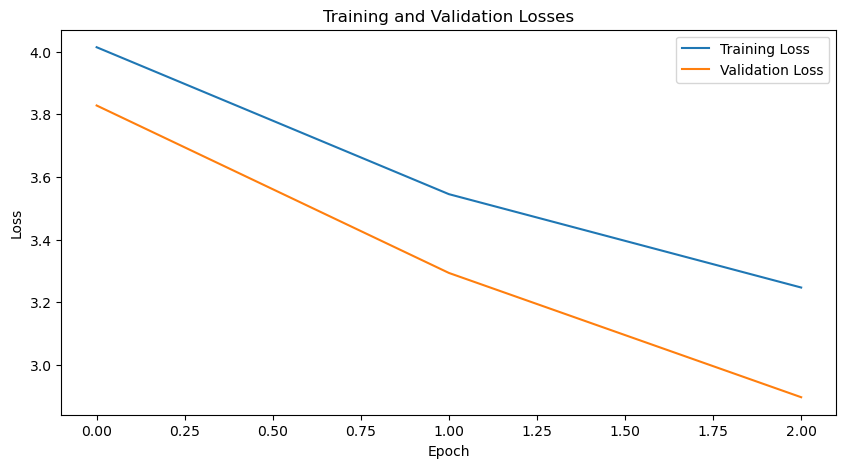

In [15]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(avg_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [18]:
# Save the model
torch.save(model.state_dict(), 'enhanced_baseball_model.pth')

In [19]:
def predict(model, player_data, game_state_data, sample=False):
    model.eval()
    with torch.no_grad():
        players = torch.tensor(player_data, dtype=torch.long).unsqueeze(0)
        game_state = torch.tensor(game_state_data, dtype=torch.float32).unsqueeze(0)
        
        pitch_pred, outcome_pred = model(players, game_state)
        
        outcome_prob = torch.softmax(outcome_pred, dim=1)
        
        if sample:
            # Sample from the probability distribution
            predicted_outcome = torch.multinomial(outcome_prob, num_samples=1).item()
        else:
            # Choose the most likely outcome (argmax)
            predicted_outcome = torch.argmax(outcome_prob, dim=1).item()
        
        return idx_to_event[predicted_outcome]

In [80]:
# Example prediction
model = model.to("cpu")
player_data = [data.iloc[5]['batter'], data.iloc[5]['pitcher']]
game_state_data = data.iloc[0][['home_score', 'away_score', 'balls', 'strikes', 'outs_when_up', 'inning']].values.astype(np.float32)

print(player_data)

predicted_event = predict(model, player_data, game_state_data, sample=True)
print(f'Predicted event: {predicted_event}')


[1327, 743]
Predicted event: other_out
